# TIDY NOTEBOOK TO MAKE ALL FIGURES FOR PAPER

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_loss_across_sparsities, plot_input_output_response
from toy_cis.plot import plot_weight_bars, plot_phase_diagram, plot_phase_diagram_training
from toy_cis.util import threshold_matrix, in_out_response, performance_across_sparsities

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [2]:
# Initialize models

"""ReLU + x model with Identity embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    name = "ReluPlusX_NoEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)


"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    name = "ReluPlusX_WithEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000,
)

In [ ]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.50

In [ ]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

In [ ]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)

fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Extract and plot weights."""

if model.cfg.We_and_Wu == True: 
    W_feat_to_neuron = einsum(model.We, model.W1,
                          "inst emb feat, inst neuron emb -> neuron feat")
    W_neuron_to_feat = einsum(model.W2, model.Wu,
                          "inst emb neuron, inst feat emb -> feat neuron")
    W = einsum(W_feat_to_neuron, W_neuron_to_feat, "neuron feat, feat neuron -> feat neuron")
else:
    W = einsum(model.W1, model.W2, 
               "inst neuron feature, inst feature neuron-> neuron feature")
    
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W.T, xax="feature", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_feature.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(W, xax="neuron", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_neuron.png" 
plt.savefig(filename, dpi=300)
plt.show

In [ ]:
"""Plot a phase diagram of loss of training sparsity vs input sparsity performance"""

"""Choose model and specify sparsities to explore"""
model_cfg = reluPlusX_res_embed_cfg

sparsities = np.array([0.1, 0.3,0.5,0.7,0.9,0.95,0.99])

"Hyperparameters"
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10
batch_sz = 1024

# Iterate over training sparsities
loss_data = []
for feat_sparsity in sparsities: 

    model = Cis(model_cfg, device=device).to(device)

    """Train the model at a given sparsity"""
    losses = model.train_reluPlusX(
            batch_sz,
            feat_sparsity,
            feat_importance,
            n_steps,
            lr, 
            logging_freq, 
    )

    """Test this model's performance across a range of sparsities"""
    loss_data = performance_across_sparsities(sparsities, model, loss_data, feat_sparsity)

# Show plot
fig = plot_phase_diagram (loss_data, model.cfg.name)
filename = f"{model.cfg.name}_phase_diagram_loss.png"
plt.savefig(filename, dpi=300)
plt.show()

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

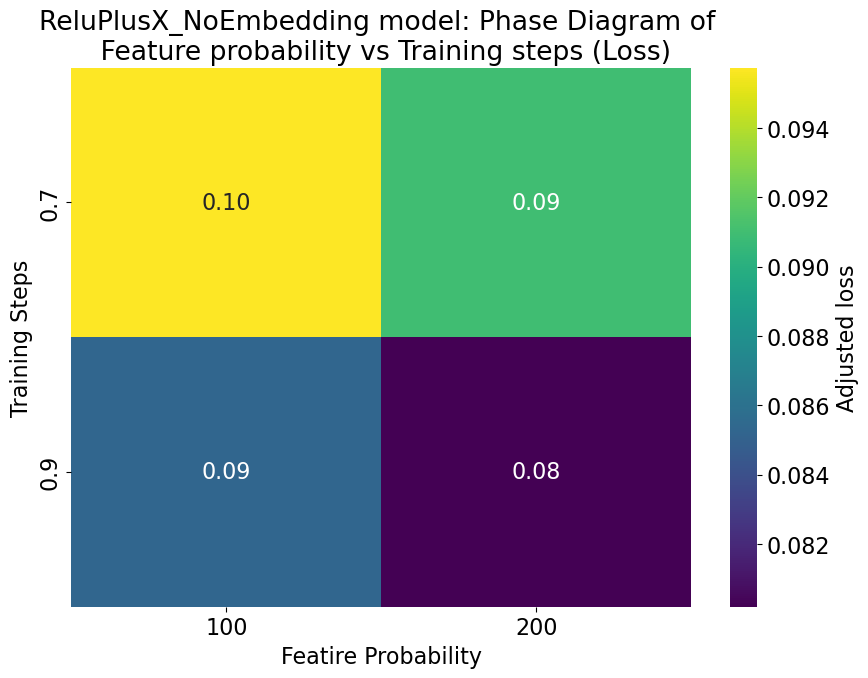

In [3]:
"""Plot training sparsity vs training steps + loss and polysemanticity"""

"Choose model, in this case only identity embedding"
model_cfg = reluPlusX_res_noEmbed_cfg

sparsities = np.array([0.1, 0.3])#, 0.5, 0.75, 0.90, 0.95, 0.99])
steps = np.array([100, 200])#[10000, 30000, 50000, 80000, 120000, 150000, 180000])
feat_importance = 1
lr = 3e-3
batch_sz = 1024

# Iterate over training sparsities
loss_data = []
for feat_sparsity in sparsities: 
    for n_steps in steps: 
    
        """Train the model at a given sparsity"""
        model = Cis(model_cfg, device=device).to(device)
        logging_freq = n_steps // 10
        losses = model.train_reluPlusX(
                batch_sz,
                feat_sparsity,
                feat_importance,
                n_steps,
                lr, 
                logging_freq, 
        )
        loss_data.append({"sparsity": feat_sparsity, "n_steps": n_steps, 
                          "loss": losses[-1]})

fig = plot_phase_diagram_training(loss_data, model.cfg.name)
filename = f"{model.cfg.name}_phase_diagram_loss.png"
plt.savefig(filename, dpi=300)
plt.show()